# Electricity Consumption Forecasting Using LSTM

In this example, the LSTM model is used to forecast electricity consumption for the Dublin City Council Civic Offices. Attributions provided below.

#### Attributions

The below code uses the LSTM model from the TensorFlow library, of which the original authors **(Copyright 2019 The TensorFlow Authors)** have made available under the Apache 2.0 license. Modifications have been made where appropriate for conducting analysis on the dataset specific to this example.

The dataset used in this example is sourced from [data.gov.ie](https://data.gov.ie/dataset/energy-consumption-gas-and-electricity-civic-offices-2009-2012/resource/6091c604-8c94-4b44-ac52-c1694e83d746).

The below work and findings are not endorsed by the original authors in any way.

#### Apache 2.0 License

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Python version

In [2]:
from platform import python_version
print(python_version())

3.6.9


### Import Libraries

In [3]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [4]:
tf.random.set_seed(1234)

In [5]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf

from math import sqrt
from numpy.random import seed
seed(1)
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM

### Data Import and Manipulation

In [6]:
# fix random seed for reproducibility
np.random.seed(7)

# load dataset
df = pd.read_csv('dccelectricitycivicsblocks34p20130221-1840.csv', engine='python', skipfooter=3)
df

,Civic Offices Blocks 3 and 4 KWh,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97
0,Date,Values,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
1,29/03/2011,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.80000305,31.20000076,31.65000153,30.60000038,32.85000229,31.05000305,32.10000229,31.35000229,31.65000153,30.15000153
2,30/03/2011,96,32.10000229,32.40000153,33.60000229,33,29.70000076,30.90000153,31.50000191,33,...,35.70000076,33.60000229,34.20000076,34.80000305,34.65000153,33.75,33.15000153,32.70000076,31.50000191,33.60000229
3,31/03/2011,96,32.10000229,33.60000229,35.10000229,33.45000076,31.20000076,31.35000038,34.20000076,33.75,...,33,33,35.25,34.35000229,32.40000153,31.20000076,32.84999847,33.45000076,32.10000229,32.10000229
4,01/04/2011,96,32.70000076,34.5,30.30000305,33,33,31.5,30.30000305,32.84999847,...,32.25,33.45000076,33,30.45000076,33.15000153,30.60000229,30.15000153,32.55000305,33,30.15000153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,13/02/2013,96,25,25,25.5,24.5,25,26,25.5,25.5,...,33,32.5,30.5,27.5,26,26,26,26,25.5,26.5
689,14/02/2013,96,26,25.5,26,25.5,25,27,25.5,26.5,...,31,30,30.5,29,28,26.5,25.5,25,25.5,25
690,15/02/2013,96,25.5,24.5,25.5,24.5,25,26.5,25,25.5,...,29,27,28,28,25.5,26,25.5,25.5,24.5,25
691,16/02/2013,96,25,25,24.5,24.5,24.5,26.5,25,25.5,...,24.5,24,24.5,26,24.5,24,25,24.5,25,24


In [7]:
df2=df.rename(columns=df.iloc[0])
df3=df2.drop(df.index[0])
df3
df3.drop(df3.index[0])
df4=df3.drop('Date', axis=1)
df5=df4.drop('Values', axis=1)
df5
df6=df5.dropna()
df7=df6.values
df7
dataset=np.sum(df7, axis=1, dtype=float)
dataset

array([4981.5001927 , 5166.60016445, 3046.35014537, 3101.10013769,
       4908.60016439, 4858.50017742, 4905.00019836, 4999.95019526,
       3075.90013122, 3023.5501442 , 5004.6001587 , 5199.30019957,
       5226.75017163, 5162.55022428, 4991.55017468, 2950.20010378,
       4883.85017776, 5055.15017129, 5084.10021592, 4914.00019451,
       3581.55014991, 2981.55008892, 2967.00011064, 3515.70014566,
       4721.10016438, 4931.85019494, 5020.05018234, 4799.40017322,
       3043.20012856, 2929.05012318, 3423.45014192, 4949.55017475,
       5155.05015188, 5238.75021174, 5129.10016059, 3088.95013995,
       3017.40010454, 5041.95018196, 5170.80017096, 5250.90023994,
       5239.35021975, 5163.60019308, 3169.65013694, 3034.65012932,
       5056.05021094, 5052.6001988 , 5048.2501869 , 4971.75019264,
       3013.20013239, 2919.45011703, 4830.0002022 , 5007.90018087,
       5028.00018885, 5088.60017207, 5092.35015869, 3069.90011787,
       2909.85011099, 4923.60022544, 5136.75021744, 5233.65021

In [8]:
tseries=dataset
tseries

array([4981.5001927 , 5166.60016445, 3046.35014537, 3101.10013769,
       4908.60016439, 4858.50017742, 4905.00019836, 4999.95019526,
       3075.90013122, 3023.5501442 , 5004.6001587 , 5199.30019957,
       5226.75017163, 5162.55022428, 4991.55017468, 2950.20010378,
       4883.85017776, 5055.15017129, 5084.10021592, 4914.00019451,
       3581.55014991, 2981.55008892, 2967.00011064, 3515.70014566,
       4721.10016438, 4931.85019494, 5020.05018234, 4799.40017322,
       3043.20012856, 2929.05012318, 3423.45014192, 4949.55017475,
       5155.05015188, 5238.75021174, 5129.10016059, 3088.95013995,
       3017.40010454, 5041.95018196, 5170.80017096, 5250.90023994,
       5239.35021975, 5163.60019308, 3169.65013694, 3034.65012932,
       5056.05021094, 5052.6001988 , 5048.2501869 , 4971.75019264,
       3013.20013239, 2919.45011703, 4830.0002022 , 5007.90018087,
       5028.00018885, 5088.60017207, 5092.35015869, 3069.90011787,
       2909.85011099, 4923.60022544, 5136.75021744, 5233.65021

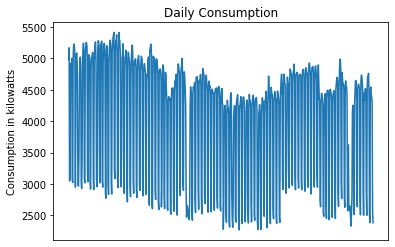

In [9]:
plt.plot(tseries)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Consumption in kilowatts')
plt.title("Daily Consumption")
plt.show()

In [10]:
df=pd.DataFrame(tseries)
df

,0
0,4981.500193
1,5166.600164
2,3046.350145
3,3101.100138
4,4908.600164
...,...
675,4390.000000
676,4385.000000
677,4289.500000
678,2564.000000


In [11]:
df

,0
0,4981.500193
1,5166.600164
2,3046.350145
3,3101.100138
4,4908.600164
...,...
675,4390.000000
676,4385.000000
677,4289.500000
678,2564.000000


In [12]:
df=np.array(df)

### Training and Validation data partition

In [13]:
train_size = int(len(df) * 0.8)
val_size = len(df) - train_size
train, val = df[0:train_size,:], df[train_size:len(df),:]

### Form dataset matrix

In [14]:
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
df

array([[4981.5001927 ],
       [5166.60016445],
       [3046.35014537],
       [3101.10013769],
       [4908.60016439],
       [4858.50017742],
       [4905.00019836],
       [4999.95019526],
       [3075.90013122],
       [3023.5501442 ],
       [5004.6001587 ],
       [5199.30019957],
       [5226.75017163],
       [5162.55022428],
       [4991.55017468],
       [2950.20010378],
       [4883.85017776],
       [5055.15017129],
       [5084.10021592],
       [4914.00019451],
       [3581.55014991],
       [2981.55008892],
       [2967.00011064],
       [3515.70014566],
       [4721.10016438],
       [4931.85019494],
       [5020.05018234],
       [4799.40017322],
       [3043.20012856],
       [2929.05012318],
       [3423.45014192],
       [4949.55017475],
       [5155.05015188],
       [5238.75021174],
       [5129.10016059],
       [3088.95013995],
       [3017.40010454],
       [5041.95018196],
       [5170.80017096],
       [5250.90023994],
       [5239.35021975],
       [5163.600

### Normalize dataset with MinMaxScaler

#### Training Data

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
train

array([[0.86253241],
       [0.921413  ],
       [0.24695818],
       [0.26437424],
       [0.8393428 ],
       [0.82340591],
       [0.83819764],
       [0.86840138],
       [0.25635808],
       [0.23970547],
       [0.86988054],
       [0.93181493],
       [0.94054681],
       [0.92012471],
       [0.86572932],
       [0.21637271],
       [0.83146979],
       [0.88596058],
       [0.89516964],
       [0.84106056],
       [0.41720613],
       [0.22634519],
       [0.22171681],
       [0.39625915],
       [0.77969876],
       [0.84673867],
       [0.87479522],
       [0.80460611],
       [0.24595616],
       [0.20964486],
       [0.36691428],
       [0.85236906],
       [0.91773892],
       [0.94436404],
       [0.90948419],
       [0.26050931],
       [0.23774913],
       [0.88176165],
       [0.92274903],
       [0.94822898],
       [0.9445549 ],
       [0.9204587 ],
       [0.2861801 ],
       [0.24323639],
       [0.88624689],
       [0.88514943],
       [0.88376569],
       [0.859

#### Validation Data

In [17]:
val = scaler.fit_transform(val)
val

array([[0.95295446],
       [0.95558901],
       [0.91738803],
       [0.31802785],
       [0.23372224],
       [0.91305984],
       [0.95013173],
       [0.95859992],
       [0.92096349],
       [0.86789612],
       [0.30466692],
       [0.2331577 ],
       [0.89593527],
       [0.96499812],
       [0.85001882],
       [0.76176139],
       [0.74275499],
       [0.15619119],
       [0.11610839],
       [0.75442228],
       [0.79488145],
       [0.78547234],
       [0.76778321],
       [0.71885585],
       [0.08242379],
       [0.05871283],
       [0.69777945],
       [0.76721867],
       [0.79092962],
       [0.79281144],
       [0.14753481],
       [0.04554008],
       [0.78001505],
       [0.81313511],
       [0.80447874],
       [0.80955965],
       [0.76439594],
       [0.03820098],
       [0.75649228],
       [0.81595785],
       [0.81878058],
       [0.80127964],
       [0.78152051],
       [0.08731652],
       [0.05212646],
       [0.74294317],
       [0.79036507],
       [0.797

### Configure LSTM model

In [18]:
# Lookback period
lookback = 5
X_train, Y_train = create_dataset(train, lookback)
X_val, Y_val = create_dataset(val, lookback)

In [19]:
X_train

array([[0.86253241, 0.921413  , 0.24695818, 0.26437424, 0.8393428 ],
       [0.921413  , 0.24695818, 0.26437424, 0.8393428 , 0.82340591],
       [0.24695818, 0.26437424, 0.8393428 , 0.82340591, 0.83819764],
       ...,
       [0.79366336, 0.8323127 , 0.84471866, 0.82467826, 0.77903069],
       [0.8323127 , 0.84471866, 0.82467826, 0.77903069, 0.2258521 ],
       [0.84471866, 0.82467826, 0.77903069, 0.2258521 , 0.18179503]])

In [20]:
Y_train

array([0.82340591, 0.83819764, 0.86840138, 0.25635808, 0.23970547,
       0.86988054, 0.93181493, 0.94054681, 0.92012471, 0.86572932,
       0.21637271, 0.83146979, 0.88596058, 0.89516964, 0.84106056,
       0.41720613, 0.22634519, 0.22171681, 0.39625915, 0.77969876,
       0.84673867, 0.87479522, 0.80460611, 0.24595616, 0.20964486,
       0.36691428, 0.85236906, 0.91773892, 0.94436404, 0.90948419,
       0.26050931, 0.23774913, 0.88176165, 0.92274903, 0.94822898,
       0.9445549 , 0.9204587 , 0.2861801 , 0.24323639, 0.88624689,
       0.88514943, 0.88376569, 0.85943092, 0.23641311, 0.20659109,
       0.81434003, 0.87093029, 0.87732413, 0.89660108, 0.89779396,
       0.25444947, 0.20353731, 0.84411434, 0.91191768, 0.94274172,
       0.95123503, 0.85303708, 0.25678752, 0.21890162, 0.40231898,
       0.91535317, 0.957104  , 0.95075787, 0.89197271, 0.25201599,
       0.23794   , 0.93157636, 0.9404991 , 0.95280964, 0.95514767,
       0.25025053, 0.21642042, 0.8609578 , 0.93424841, 0.94355

In [21]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [22]:
X_train.shape[0]

538

In [23]:
X_train.shape[1]

1

Epoch 1/100
430/430 - 1s - loss: 0.1244 - val_loss: 0.0800
Epoch 2/100
430/430 - 0s - loss: 0.0865 - val_loss: 0.0670
Epoch 3/100
430/430 - 0s - loss: 0.0741 - val_loss: 0.0599
Epoch 4/100
430/430 - 0s - loss: 0.0664 - val_loss: 0.0550
Epoch 5/100
430/430 - 0s - loss: 0.0626 - val_loss: 0.0495
Epoch 6/100
430/430 - 0s - loss: 0.0594 - val_loss: 0.0466
Epoch 7/100
430/430 - 0s - loss: 0.0572 - val_loss: 0.0443
Epoch 8/100
430/430 - 0s - loss: 0.0546 - val_loss: 0.0425
Epoch 9/100
430/430 - 0s - loss: 0.0530 - val_loss: 0.0402
Epoch 10/100
430/430 - 0s - loss: 0.0514 - val_loss: 0.0385
Epoch 11/100
430/430 - 0s - loss: 0.0498 - val_loss: 0.0370
Epoch 12/100
430/430 - 0s - loss: 0.0475 - val_loss: 0.0357
Epoch 13/100
430/430 - 0s - loss: 0.0467 - val_loss: 0.0341
Epoch 14/100
430/430 - 0s - loss: 0.0451 - val_loss: 0.0338
Epoch 15/100
430/430 - 0s - loss: 0.0436 - val_loss: 0.0347
Epoch 16/100
430/430 - 0s - loss: 0.0416 - val_loss: 0.0335
Epoch 17/100
430/430 - 0s - loss: 0.0409 - val_lo

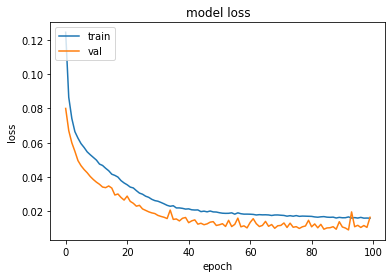

In [24]:
# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, lookback)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=1, verbose=2)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
# Generate predictions
trainpred = model.predict(X_train)
valpred = model.predict(X_val)

In [26]:
trainpred

array([[ 7.61172891e-01],
       [ 6.65939510e-01],
       [ 6.89693093e-01],
       [ 5.41155696e-01],
       [ 8.50655288e-02],
       [ 6.64793193e-01],
       [ 8.01993191e-01],
       [ 8.57512057e-01],
       [ 8.64545941e-01],
       [ 6.07056975e-01],
       [ 1.50283784e-01],
       [ 2.43654206e-01],
       [ 7.82543957e-01],
       [ 5.67021251e-01],
       [ 4.20709372e-01],
       [ 5.01879573e-01],
       [ 1.15418002e-01],
       [ 5.83577871e-01],
       [ 6.57104194e-01],
       [ 4.09800738e-01],
       [ 7.66023517e-01],
       [ 8.36076796e-01],
       [ 7.68431067e-01],
       [ 3.05801719e-01],
       [ 1.23215124e-01],
       [ 6.98755801e-01],
       [ 6.01971149e-01],
       [ 8.68929446e-01],
       [ 9.10225511e-01],
       [ 8.88893068e-01],
       [ 4.66248453e-01],
       [ 1.35801956e-01],
       [ 7.99421847e-01],
       [ 8.35566282e-01],
       [ 8.37232590e-01],
       [ 8.71205270e-01],
       [ 6.63683951e-01],
       [ 1.76291049e-01],
       [ 1.8

In [27]:
valpred

array([[ 0.78059536],
       [ 0.85216075],
       [ 0.8596638 ],
       [ 0.84013027],
       [ 0.5879245 ],
       [ 0.15643734],
       [ 0.2442825 ],
       [ 0.7705004 ],
       [ 0.83216566],
       [ 0.89355016],
       [ 0.66253465],
       [ 0.28080374],
       [ 0.24003242],
       [ 0.30283022],
       [ 0.7143531 ],
       [ 0.77083063],
       [ 0.76468265],
       [ 0.7227573 ],
       [ 0.5232567 ],
       [ 0.14202899],
       [ 0.17663163],
       [ 0.7227254 ],
       [ 0.7711052 ],
       [ 0.77346337],
       [ 0.7929493 ],
       [ 0.6683411 ],
       [ 0.03789349],
       [ 0.6743761 ],
       [ 0.8521585 ],
       [ 0.8156034 ],
       [ 0.7628473 ],
       [ 0.6708208 ],
       [ 0.1513918 ],
       [ 0.178669  ],
       [ 0.81149966],
       [ 0.64185894],
       [ 0.46572456],
       [ 0.6687512 ],
       [ 0.16599926],
       [ 0.16440064],
       [ 0.77295387],
       [ 0.83074665],
       [ 0.7999603 ],
       [ 0.7937307 ],
       [ 0.688232  ],
       [ 0

In [28]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
valpred = scaler.inverse_transform(valpred)
Y_val = scaler.inverse_transform([Y_val])
predictions = valpred

In [29]:
Y_train.shape

(1, 538)

In [30]:
Y_val.shape

(1, 130)

In [31]:
X_train.shape

(538, 1, 5)

In [32]:
X_val.shape

(130, 1, 5)

In [33]:
Y_train

array([[4518.28951509, 4557.59113815, 4637.8424781 , 3011.6434176 ,
        2967.39742769, 4641.77260773, 4806.33226731, 4829.53286879,
        4775.27134202, 4630.74281586, 2905.40228055, 4539.71522927,
        4684.49726678, 4708.96572332, 4565.19789723, 3439.01669686,
        2931.89915677, 2919.60157603, 3383.3605489 , 4402.1595992 ,
        4580.28464288, 4654.83090304, 4468.33843892, 2984.00551222,
        2887.52640548, 3305.39123188, 4595.24459172, 4768.93231222,
        4839.67525246, 4746.9994882 , 3022.67323035, 2962.19943991,
        4673.34069105, 4782.24416242, 4849.94440544, 4840.18237672,
        4776.15877125, 3090.88053001, 2976.77908865, 4685.25797653,
        4682.34204071, 4678.66542886, 4614.00795392, 2958.64964103,
        2879.41252047, 4494.20145533, 4644.56177266, 4661.55021527,
        4712.76906743, 4715.93854042, 3006.57223143, 2871.29863554,
        4573.31180319, 4753.46528423, 4835.36475348, 4857.93146626,
        4597.01951125, 3012.78443227, 2912.12160

In [34]:
Y_val

array([[4756.5, 4855. , 4877.5, 4777.5, 4636.5, 3140. , 2950. , 4711. ,
        4894.5, 4589. , 4354.5, 4304. , 2745.5, 2639. , 4335. , 4442.5,
        4417.5, 4370.5, 4240.5, 2549.5, 2486.5, 4184.5, 4369. , 4432. ,
        4437. , 2722.5, 2451.5, 4403. , 4491. , 4468. , 4481.5, 4361.5,
        2432. , 4340.5, 4498.5, 4506. , 4459.5, 4407. , 2562.5, 2469. ,
        4304.5, 4430.5, 4449.5, 4484. , 4335. , 2695. , 2451. , 4500. ,
        4581. , 4679. , 4696. , 4632.5, 2873. , 2643. , 4475. , 4771. ,
        4965. , 4987.5, 4809. , 3042.5, 2769. , 4774.5, 4660.5, 4576. ,
        4589. , 4491.5, 2774.5, 2630.5, 4564. , 4640. , 4540.5, 4547.5,
        4399. , 2658.5, 2572.5, 3622.5, 2584.5, 2599.5, 2650. , 2576. ,
        2460. , 2330.5, 2560.5, 2803. , 4152. , 4252. , 4177.5, 2566.5,
        2512. , 4333.5, 4477.5, 4644.5, 4646.5, 4487.5, 2741.5, 2637. ,
        4518. , 4579.5, 4589. , 4537. , 4526. , 2771. , 2510. , 4639. ,
        4731. , 4709.5, 4638.5, 4454. , 2869.5, 2503.5, 4448.5, 

In [35]:
X_train

array([[[0.86253241, 0.921413  , 0.24695818, 0.26437424, 0.8393428 ]],

       [[0.921413  , 0.24695818, 0.26437424, 0.8393428 , 0.82340591]],

       [[0.24695818, 0.26437424, 0.8393428 , 0.82340591, 0.83819764]],

       ...,

       [[0.79366336, 0.8323127 , 0.84471866, 0.82467826, 0.77903069]],

       [[0.8323127 , 0.84471866, 0.82467826, 0.77903069, 0.2258521 ]],

       [[0.84471866, 0.82467826, 0.77903069, 0.2258521 , 0.18179503]]])

In [36]:
X_val

array([[[0.95295446, 0.95558901, 0.91738803, 0.31802785, 0.23372224]],

       [[0.95558901, 0.91738803, 0.31802785, 0.23372224, 0.91305984]],

       [[0.91738803, 0.31802785, 0.23372224, 0.91305984, 0.95013173]],

       [[0.31802785, 0.23372224, 0.91305984, 0.95013173, 0.95859992]],

       [[0.23372224, 0.91305984, 0.95013173, 0.95859992, 0.92096349]],

       [[0.91305984, 0.95013173, 0.95859992, 0.92096349, 0.86789612]],

       [[0.95013173, 0.95859992, 0.92096349, 0.86789612, 0.30466692]],

       [[0.95859992, 0.92096349, 0.86789612, 0.30466692, 0.2331577 ]],

       [[0.92096349, 0.86789612, 0.30466692, 0.2331577 , 0.89593527]],

       [[0.86789612, 0.30466692, 0.2331577 , 0.89593527, 0.96499812]],

       [[0.30466692, 0.2331577 , 0.89593527, 0.96499812, 0.85001882]],

       [[0.2331577 , 0.89593527, 0.96499812, 0.85001882, 0.76176139]],

       [[0.89593527, 0.96499812, 0.85001882, 0.76176139, 0.74275499]],

       [[0.96499812, 0.85001882, 0.76176139, 0.74275499, 0.15619

### Screen Prediction Accuracy on Validation Data

In [37]:
# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_val[0], valpred[:,0]))
print('Validation Score: %.2f RMSE' % (valScore))

Train Score: 348.40 RMSE
Validation Score: 410.12 RMSE


In [38]:
# Train predictions
trainpredPlot = np.empty_like(df)
trainpredPlot[:, :] = np.nan
trainpredPlot[lookback:len(trainpred)+lookback, :] = trainpred

In [39]:
# Validation predictions
valpredPlot = np.empty_like(df)
valpredPlot[:, :] = np.nan
valpredPlot[len(trainpred)+(lookback*2)+1:len(df)-1, :] = valpred

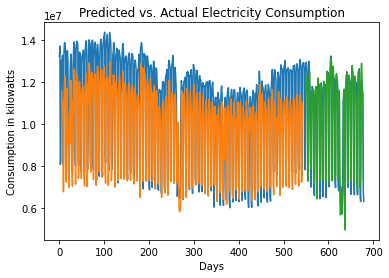

In [40]:
# Plot all predictions
inversetransform, =plt.plot(scaler.inverse_transform(df))
trainpred, =plt.plot(scaler.inverse_transform(trainpredPlot))
valpred, =plt.plot(scaler.inverse_transform(valpredPlot))
plt.xlabel('Days')
plt.ylabel('Consumption in kilowatts')
plt.title("Predicted vs. Actual Electricity Consumption")
plt.show()

In [41]:
Y_val=Y_val.reshape(-1)
Y_val.shape
Y_val=pd.Series(Y_val)

In [42]:
Y_val

0      4756.5
1      4855.0
2      4877.5
3      4777.5
4      4636.5
        ...  
125    4543.0
126    4390.0
127    4385.0
128    4289.5
129    2564.0
Length: 130, dtype: float64

In [43]:
predictions=predictions.reshape(-1)
predictions.shape
predictions=pd.Series(predictions)

In [44]:
predictions

0      4404.541992
1      4594.691406
2      4614.626953
3      4562.726074
4      3892.615234
          ...     
125    4856.977051
126    4610.048340
127    4354.295898
128    3924.254395
129    2776.141113
Length: 130, dtype: float32

In [45]:
import numpy as np

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [46]:
mda(Y_val, predictions)

0.9846153846153847

In [47]:
# https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/

mse = mean_squared_error(Y_val, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 410.116102


In [48]:
np.mean(Y_val)

3909.15

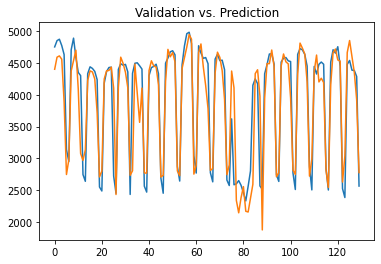

In [49]:
plt.plot(Y_val)
plt.plot(predictions)
plt.title("Validation vs. Prediction")
plt.show()